# **Analysis of NIO**

In [32]:
!pip install -q basemap

     |████████████████████████████████| 864 kB 7.6 MB/s 
     |████████████████████████████████| 46 kB 5.2 MB/s 
     |████████████████████████████████| 30.5 MB 1.2 MB/s 
     |████████████████████████████████| 6.3 MB 41.7 MB/s 


In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime as dt
import warnings
warnings.simplefilter("ignore")
import plotly.express as px
from textwrap import wrap
import scipy
import math as Math

In [33]:
from geopy.distance import great_circle as vc
from mpl_toolkits.basemap import Basemap

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import colours
named_colorscales = px.colors.named_colorscales()
print("\n".join(wrap("".join('{:<12}'.format(c) for c in named_colorscales), 96)))

aggrnyl     agsunset    blackbody   bluered     blues       blugrn      bluyl       brwnyl
bugn        bupu        burg        burgyl      cividis     darkmint    electric    emrld
gnbu        greens      greys       hot         inferno     jet         magenta     magma
mint        orrd        oranges     oryel       peach       pinkyl      plasma      plotly3
pubu        pubugn      purd        purp        purples     purpor      rainbow     rdbu
rdpu        redor       reds        sunset      sunsetdark  teal        tealgrn     turbo
viridis     ylgn        ylgnbu      ylorbr      ylorrd      algae       amp         deep
dense       gray        haline      ice         matter      solar       speed       tempo
thermal     turbid      armyrose    brbg        earth       fall        geyser      prgn
piyg        picnic      portland    puor        rdgy        rdylbu      rdylgn      spectral
tealrose    temps       tropic      balance     curl        delta       oxy         edge
hsv     

In [34]:
df = pd.read_csv("/content/drive/MyDrive/indian_new.csv")

In [35]:
df.head()

,ID,Name,Date,Time,Latitude,Longitude,Maximum Wind,Status,Estimated Central Pressure,Pressure Drop
0,A1,AMPHAN,20200516,0,10.4N,87.0E,25,D,1000,3
1,A1,AMPHAN,20200516,300,10.7N,86.5E,25,D,1000,3
2,A1,AMPHAN,20200516,600,10.9N,86.3E,25,D,1000,3
3,A1,AMPHAN,20200516,900,10.9N,86.3E,30,DD,998,5
4,A1,AMPHAN,20200516,1200,10.9N,86.3E,35,CS,996,7


In [65]:
df.Status.unique()

array(['D', 'DD', 'CS', 'SCS', 'VSCS', 'ESCS', 'SuCS'], dtype=object)

In [36]:
df.Time.unique()

array([   0,  300,  600,  900, 1200, 1500, 1800, 2100])

CS      913
D       614
DD      541
VSCS    351
SCS     318
ESCS    201
SuCS     27
Name: Status, dtype: int64


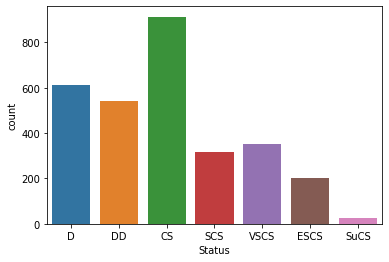

In [68]:
sns.countplot(x = 'Status', data = df)
print(df.Status.value_counts())

In [37]:
df.columns

Index(['ID', 'Name', 'Date', 'Time', 'Latitude', 'Longitude', 'Maximum Wind',
       'Status', 'Estimated Central Pressure', 'Pressure Drop'],
      dtype='object')

In [38]:
df.dtypes

ID                            object
Name                          object
Date                           int64
Time                           int64
Latitude                      object
Longitude                     object
Maximum Wind                   int64
Status                        object
Estimated Central Pressure     int64
Pressure Drop                  int64
dtype: object

**Total amount of hurricanes we have in our dataset**

In [39]:
total_cyclone_count = len(pd.unique(df['ID']))
print(total_cyclone_count)

97


**Create a unique key for all of the cyclones**

In [64]:
df['ID'] = df['ID']+ '-' + df['Name']

**Drop unnecessary titles**

In [40]:
#df.drop(['ID', 'Time' ,'Name'], axis = 1)

**Removing Hemisphere tags from coordiantes**

In [41]:
#df['Longitude'] = df['Longitude'].map(lambda x: x.rstrip('W'))
df['Latitude'] = df['Latitude'].map(lambda x: x.rstrip('N'))
#df['Latitude'] = df['Latitude'].map(lambda x: x.rstrip('S'))
df['Longitude'] = df['Longitude'].map(lambda x: x.rstrip('E'))

**Converting Latitude and Longitude to floats**

In [42]:
df['Latitude'] = df['Latitude'].astype(float)
df['Longitude'] = df['Longitude'].astype(float)

**Filtering outside latitudes**

In [43]:
lat_filtered_df = df[(df['Latitude'].astype(float) >= float(-30)) & (df['Latitude'].astype(float) <= float(30))]
print(lat_filtered_df.shape)

(2965, 10)


**Filtering outside longitude**

In [44]:
lat_long_filtered_df = lat_filtered_df[(lat_filtered_df['Longitude'] >= 40) & (lat_filtered_df['Longitude'] <= float(100))]
print(lat_long_filtered_df.shape)
#convert longitude to negative
#lat_filtered_df['Longitude'] = (lat_filtered_df['Longitude'] * -1)

(2965, 10)


**Checking for negative wind speed values**

In [45]:
negatives = []
for i in lat_long_filtered_df['Maximum Wind']:
    if float(i) < 0:
        negatives.append(i)
        
print(negatives)

[]


In [46]:
lat_long_filtered_df = lat_filtered_df[(lat_filtered_df['Maximum Wind'] >= 0)]
print(lat_long_filtered_df.shape)

(2965, 10)


**Converting all data to strings so can be searched**

In [47]:
all_columns = list(lat_long_filtered_df) # Creates list of all column headers
lat_long_filtered_df[all_columns] = lat_long_filtered_df[all_columns].astype(str)

In [48]:
lat_long_filtered_df.head()

,ID,Name,Date,Time,Latitude,Longitude,Maximum Wind,Status,Estimated Central Pressure,Pressure Drop
0,A1,AMPHAN,20200516,0,10.4,87.0,25,D,1000,3
1,A1,AMPHAN,20200516,300,10.7,86.5,25,D,1000,3
2,A1,AMPHAN,20200516,600,10.9,86.3,25,D,1000,3
3,A1,AMPHAN,20200516,900,10.9,86.3,30,DD,998,5
4,A1,AMPHAN,20200516,1200,10.9,86.3,35,CS,996,7


In [49]:
#Converting all '-999' null values to 'NaN' which Python can automatically remove:
#lat_long_filtered_df = lat_long_filtered_df.replace('-999', np.nan)

#the year 1967 has '-99' as maximum wind speed values - these must also be changed
#lat_long_filtered_df = lat_long_filtered_df.replace('-99', np.nan)
#lat_long_filtered_df

**Changing date format**

In [50]:
#df['DateTime'] = pd.to_datetime(df['date'].astype(str), format='%Y%m%d')
lat_long_filtered_df['Date'] = pd.to_datetime(lat_long_filtered_df['Date'].astype(str), format = '%Y %m %d')
lat_long_filtered_df.head()

,ID,Name,Date,Time,Latitude,Longitude,Maximum Wind,Status,Estimated Central Pressure,Pressure Drop
0,A1,AMPHAN,2020-05-16,0,10.4,87.0,25,D,1000,3
1,A1,AMPHAN,2020-05-16,300,10.7,86.5,25,D,1000,3
2,A1,AMPHAN,2020-05-16,600,10.9,86.3,25,D,1000,3
3,A1,AMPHAN,2020-05-16,900,10.9,86.3,30,DD,998,5
4,A1,AMPHAN,2020-05-16,1200,10.9,86.3,35,CS,996,7


**Adding year column**

In [51]:
lat_long_filtered_df['Year'] = lat_long_filtered_df['Date'].map(lambda x: x.year)
lat_long_filtered_df.head()

,ID,Name,Date,Time,Latitude,Longitude,Maximum Wind,Status,Estimated Central Pressure,Pressure Drop,Year
0,A1,AMPHAN,2020-05-16,0,10.4,87.0,25,D,1000,3,2020
1,A1,AMPHAN,2020-05-16,300,10.7,86.5,25,D,1000,3,2020
2,A1,AMPHAN,2020-05-16,600,10.9,86.3,25,D,1000,3,2020
3,A1,AMPHAN,2020-05-16,900,10.9,86.3,30,DD,998,5,2020
4,A1,AMPHAN,2020-05-16,1200,10.9,86.3,35,CS,996,7,2020


**Maximum Wind Speed Information Year-wise**

In [52]:
lat_long_filtered_df['Maximum Wind'] = lat_long_filtered_df['Maximum Wind'].astype(float)
lat_long_filtered_df.Year = lat_long_filtered_df.Year.astype(int)

In [53]:
grouped_df = lat_long_filtered_df.groupby(['Year'])
described_df = grouped_df.describe()
described_df = described_df.reset_index()
described_df = pd.DataFrame(described_df)

described_df.columns = ['Year', 'Data Count', "Mean", 'std', 'min', '25%', '50%', '75%', 'Max']
described_df

,Year,Data Count,Mean,std,min,25%,50%,75%,Max
0,2001,60.0,63.016667,28.771744,25.0,35.00,55.0,90.00,115.0
1,2002,104.0,31.346154,6.002862,25.0,25.00,30.0,35.00,55.0
2,2003,123.0,42.032520,13.334250,25.0,30.00,35.0,55.00,75.0
3,2004,115.0,41.365217,12.195290,25.0,30.00,45.0,45.00,90.0
4,2005,136.0,33.750000,6.824520,20.0,30.00,35.0,35.00,45.0
5,2006,106.0,38.207547,21.438602,25.0,25.00,30.0,42.50,100.0
6,2007,126.0,57.976190,31.498435,25.0,30.00,45.0,90.00,127.0
7,2008,117.0,43.239316,18.107747,20.0,30.00,35.0,65.00,90.0
8,2009,106.0,33.018868,7.611997,20.0,26.25,30.0,40.00,60.0
9,2010,159.0,44.371069,17.778010,20.0,30.00,40.0,55.00,105.0


**Creating bar chart, of year, count, and average speed**

In [54]:
import plotly.express as px
fig = px.bar(described_df, x = 'Year', y = 'Data Count', color = 'Mean', color_continuous_scale = px.colors.sequential.OrRd,
               title = 'Average Wind Speed of Large Storms in Indian Ocean by Year (2001-2020)', labels = {'Count':'Number of Large Storms', 'Mean' : 'Average Wind <br> Speed (knots)'}, text_auto = True)

plt.tight_layout()
fig.update_layout(title_x = 0.5)
fig.show()

<Figure size 432x288 with 0 Axes>

**Maximum Wind Speed information Month-wise**

In [55]:
month_df = lat_long_filtered_df
month_df = month_df.drop(['Year'], axis = 1)

month_df['Month'] = month_df['Date'].map(lambda x: x.month)

In [56]:
month_df['Maximum Wind'] = month_df['Maximum Wind'].astype(float)
month_df.Month = month_df.Month.astype(int)

grouped_df_month = month_df.groupby(['Month'])

described_df_month = grouped_df_month.describe()

described_df_month = described_df_month.reset_index()


described_df_month= pd.DataFrame(described_df_month)

described_df_month.columns = ['Month', 'Data Count', "Mean", 'std', 'min', '25%', '50%', '75%', 'Max']
described_df_month

,Month,Data Count,Mean,std,min,25%,50%,75%,Max
0,1,67.0,31.119403,6.325807,20.0,25.0,30.0,35.0,45.0
1,4,141.0,49.148936,20.684341,20.0,35.0,45.0,65.0,100.0
2,5,585.0,49.200000,23.992350,20.0,30.0,40.0,55.0,130.0
3,6,277.0,48.014440,22.535635,20.0,30.0,45.0,65.0,127.0
4,7,60.0,28.166667,4.599803,20.0,25.0,30.0,30.0,40.0
5,8,9.0,20.000000,0.000000,20.0,20.0,20.0,20.0,20.0
6,9,125.0,32.120000,11.609646,20.0,25.0,30.0,30.0,75.0
7,10,546.0,52.069597,29.614073,20.0,30.0,40.0,70.0,130.0
8,11,706.0,43.420680,19.831348,20.0,30.0,35.0,55.0,115.0
9,12,449.0,40.556793,16.078130,20.0,30.0,35.0,50.0,85.0


**Creating bar chart, of month, count, and average speed**

In [57]:
fig = px.bar(described_df_month, x = 'Month', y = 'Data Count', color = 'Mean', color_continuous_scale = px.colors.sequential.OrRd,
               title = 'Average Max. Wind Speed of Large Storms in Indian Ocean by Month (2002-2020)', text = 'Mean', labels={'Count':'Number of Large Storms', 'Mean' : 'Average Maximum <br> Wind Speed (knots)'})

fig.update_layout(title_x = 0.5, xaxis = dict(tickmode = 'array', tickvals = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], ticktext = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']))
fig.update_traces(texttemplate = '%{text:.2s}', textposition = 'outside')
fig.update_layout(uniformtext_minsize = 8, uniformtext_mode = 'hide')
fig.show()

**Dataframe of number of days of storm every year**

In [58]:
number_of_storms = {}
count = lat_long_filtered_df['Year'].value_counts()
count_df = pd.DataFrame(count)
count_df = count_df.reset_index()
count_df = count_df.rename(columns = {"index": "Year", "Year": "Number of days of storm"})
count_df = count_df.sort_values(by = "Year", ascending = True)
count_df

,Year,Number of days of storm
18,2001,60
17,2002,104
10,2003,123
13,2004,115
8,2005,136
16,2006,106
9,2007,126
12,2008,117
15,2009,106
4,2010,159


In [59]:
lat_long_filtered_df = lat_long_filtered_df.sort_values(by = 'Maximum Wind', ascending = False)
lat_long_filtered_df.head()

,ID,Name,Date,Time,Latitude,Longitude,Maximum Wind,Status,Estimated Central Pressure,Pressure Drop,Year
340,B5,KYARR,2019-10-27,1800,17.8,66.3,130.0,SuCS,922,84,2019
22,A1,AMPHAN,2020-05-18,1800,14.9,86.5,130.0,SuCS,920,84,2020
338,B5,KYARR,2019-10-27,1200,17.5,66.7,130.0,SuCS,922,84,2019
337,B5,KYARR,2019-10-27,900,17.4,67.0,130.0,SuCS,922,84,2019
339,B5,KYARR,2019-10-27,1500,17.5,66.5,130.0,SuCS,922,84,2019


**Dropping duplicate storms**

In [60]:
lat_long_filtered_df = lat_long_filtered_df.drop_duplicates(subset = 'Name', keep = "first")
lat_long_filtered_df.head()

,ID,Name,Date,Time,Latitude,Longitude,Maximum Wind,Status,Estimated Central Pressure,Pressure Drop,Year
340,B5,KYARR,2019-10-27,1800,17.8,66.3,130.0,SuCS,922,84,2019
22,A1,AMPHAN,2020-05-18,1800,14.9,86.5,130.0,SuCS,920,84,2020
2232,N2,GONU,2007-06-04,1500,20.0,64.0,127.0,SuCS,920,80,2007
1494,H2,PHAILIN,2013-10-11,1800,17.0,87.0,115.0,ESCS,940,66,2013
1176,F4,CHAPALA,2015-10-28,1800,13.0,64.7,115.0,DD,1001,5,2015


In [61]:
lat_long_filtered_df.shape

(80, 11)

In [62]:
lat_long_filtered_df = lat_long_filtered_df.sort_values(by = 'Year', ascending = True)
lat_long_filtered_df.shape

(80, 11)

In [63]:
lat_long_filtered_df.head()

,ID,Name,Date,Time,Latitude,Longitude,Maximum Wind,Status,Estimated Central Pressure,Pressure Drop,Year
2932,T1,01A,2001-05-25,0,17.0,67.5,115.0,ESCS,932,66,2001
2871,S3,04B,2002-11-27,600,17.0,90.5,35.0,CS,1004,8,2002
2900,S4,05B,2002-12-25,0,7.0,83.5,35.0,CS,1002,8,2002
2762,R2,02A,2003-11-13,900,6.2,57.7,55.0,SCS,990,14,2003
2790,R3,03B,2003-12-14,1200,12.0,83.5,55.0,SCS,992,14,2003


In [80]:
# Since our unique keys are strings, we enumerate them to access them as integers 
keys = list(enumerate(pd.unique(df['ID'])))

y = np.zeros((total_cyclone_count))
for x in range(0, total_cyclone_count):
    y[x] = len(pd.DataFrame(df[df['ID'] == keys[x][1]], columns = df.keys()).reset_index(drop = True))
    
# Now contains how many time instances of data (or rows) each cyclone contains 
cyclone_amount = pd.DataFrame(y)

In [81]:
# Print the cyclone key with the amount of data they contain
print ('Top 6 Hurricanes (in terms of data quantity)')
for x in cyclone_amount.nlargest(6, 0).index:
    print (keys[x][1], "-", cyclone_amount.loc[x][0], "data points")
    


Top 6 Hurricanes (in terms of data quantity)
R1-01B - 78.0 data points
B5-KYARR - 74.0 data points
B6-MAHA - 68.0 data points
B2-FANI - 64.0 data points
C4-LUBAN - 64.0 data points
C6-GAJA - 63.0 data points


In [82]:
cyclone_amount.describe()

,0
count,97.000000
mean,30.567010
std,16.128977
min,1.000000
25%,19.000000
50%,27.000000
75%,41.000000
max,78.000000


*We can see that the shortest cyclone only has 1 row of information and the largest cyclone has 78 rows*

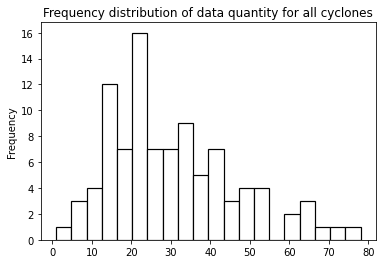

In [83]:
dist = cyclone_amount.plot.hist(bins = 20, edgecolor = 'black', histtype = 'barstacked', color = 'white', legend = None, linewidth = 1.2)
plt.title("Frequency distribution of data quantity for all cyclones")
plt.show()

**Total amount of data tuples**

In [84]:
total_data_count = len(df)
print(total_data_count)

2965


In [85]:
y = np.zeros(total_cyclone_count)
df['distance'] = np.zeros(total_data_count)
df['direction'] = np.zeros(total_data_count)

In [86]:
# For all cyclones
for x in range(0, total_cyclone_count):
    t = pd.DataFrame(df[df['ID'] == keys[x][1]], columns = df.keys()).reset_index(drop = False)
    dst = 0
    prev = (0,0)
    
    # For all latitude and longitude points of cyclones, calculate the angle of travel and distance
    for p in zip(t['Latitude'], t['Longitude']):
        
        if prev == (0,0):
            prev = p
            continue 
        # Stores the distance into the DataFrame
        #data.set_value(t[(t['Latitude'] == p[0]) & (t['Longitude'] == p[1])]['index'].values[0], 'distance', vc(prev,p).miles)
        df.at[t[(t['Latitude'] == p[0]) & (t['Longitude'] == p[1])]['index'].values[0], 'distance'] = vc(prev, p).miles

        dLon = p[1] - prev[1];  
        temp = float(p[0])
        y_x = Math.sin(dLon) * Math.cos(temp);
        
        x_x = Math.cos(p[1]) * Math.sin(temp) - Math.sin(p[1]) * Math.cos(temp) * Math.cos(dLon);
        brng = Math.degrees(Math.atan2(y_x, x_x)) 
        if (brng < 0):
            brng+= 360;
        
        # Stores the angle of travel into the DataFrame
        #data.set_value(t[(t['Lat'] == p[0]) & (t['Long'] == p[1])]['index'].values[0], 'direction', brng)
        df.at[t[(t['Latitude'] == p[0]) & (t['Longitude'] == p[1])]['index'].values[0], 'direction'] = brng

        dst += vc(prev,p).miles
        prev = p
    y[x] = dst

# Now contains the distance between all given latitude and longitude points
cyclone_distance = pd.DataFrame(y)

In [87]:
df.head()

,ID,Name,Date,Time,Latitude,Longitude,Maximum Wind,Status,Estimated Central Pressure,Pressure Drop,distance,direction
0,A1-AMPHAN,AMPHAN,20200516,0,10.4,87.0,25,D,1000,3,0.000000,0.000000
1,A1-AMPHAN,AMPHAN,20200516,300,10.7,86.5,25,D,1000,3,39.788365,158.558803
2,A1-AMPHAN,AMPHAN,20200516,600,10.9,86.3,25,D,1000,3,0.000000,180.000000
3,A1-AMPHAN,AMPHAN,20200516,900,10.9,86.3,30,DD,998,5,0.000000,0.000000
4,A1-AMPHAN,AMPHAN,20200516,1200,10.9,86.3,35,CS,996,7,0.000000,0.000000


In [88]:
print(cyclone_distance.shape)

(97, 1)


In [89]:
cyclone_distance.describe()

,0
count,97.000000
mean,864.776497
std,436.499525
min,0.000000
25%,611.546725
50%,827.784598
75%,1116.506194
max,2138.150042


In [90]:
# Print the cyclone key with the amount of data they contain
print ('Top 6 Hurricanes (in terms of distance traveled)')
for x in cyclone_distance.nlargest(6, 0).index:
    print (keys[x][1], ":", cyclone_distance.loc[x][0], "(miles:", cyclone_amount.loc[x][0], ")")

Top 6 Hurricanes (in terms of distance traveled)
C6-GAJA : 2138.1500415889195 (miles: 63.0 )
B2-FANI : 1870.4125150459786 (miles: 64.0 )
H1-VIYARU : 1856.8997270549241 (miles: 49.0 )
B6-MAHA : 1800.4804197719234 (miles: 68.0 )
B5-KYARR : 1707.2186764395922 (miles: 74.0 )
G3-HUDHUD : 1634.6889097913006 (miles: 53.0 )


In [92]:
print(np.corrcoef(cyclone_distance[0], cyclone_amount[0]))

[[1.         0.76569147]
 [0.76569147 1.        ]]


**Amount of cyclone distance traveled vs the amount of data they contain**

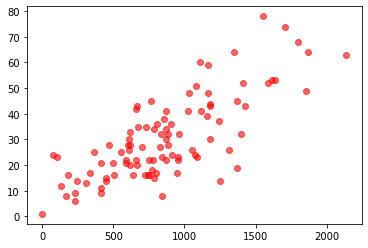

In [94]:
corr = plt.scatter(cyclone_distance[0], cyclone_amount[0], color='red',alpha = 0.6)
plt.show()

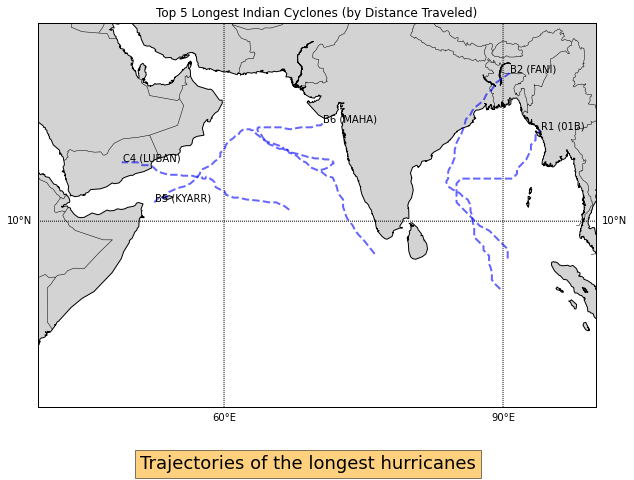

In [100]:
n = 5 # Number of cyclones

# Graph the trajectories of the longest hurricanes (the ones that traveled the most)
plt.figure(figsize=(10, 10))
m = Basemap(llcrnrlon = 40., llcrnrlat = -10., urcrnrlon = 100., urcrnrlat = 30., rsphere = (6378137.00,6356752.3142), resolution = 'l', projection = 'merc', lat_0 = 40., lon_0 = -20., lat_ts = 20.)

m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color = 'white')
m.fillcontinents(color = '#D3D3D3')
m.drawparallels(np.arange(10,90,20), labels = [1,1,0,1])
m.drawmeridians(np.arange(-180,180,30), labels = [1,1,0,1])

for x in cyclone_amount.nlargest(n,0).index:
    largest_hurr = df[df['ID'] == keys[x][1]]
    lat = largest_hurr['Latitude'].values
    long = largest_hurr['Longitude'].values
    xpt, ypt = m(long, lat)
    plt.text(xpt[len(lat) - 1] + 10000, ypt[len(long) - 1] + 10000, '%s (%s)' % (keys[x][1].split('-')[0],keys[x][1].split('-')[1]))
    m.plot(xpt, ypt, linewidth=2, color = 'blue', linestyle = 'dashed', alpha = 0.6)
    
plt.title('Top 5 Longest Indian Cyclones (by Distance Traveled)')
plt.figtext(0.5, 0.15, "Trajectories of the longest hurricanes", ha = "center", fontsize = 18, bbox = {"facecolor": "orange", "alpha": 0.5, "pad": 5});

Text(0.5, 0.15, 'Trajectories of the smallest cyclones')

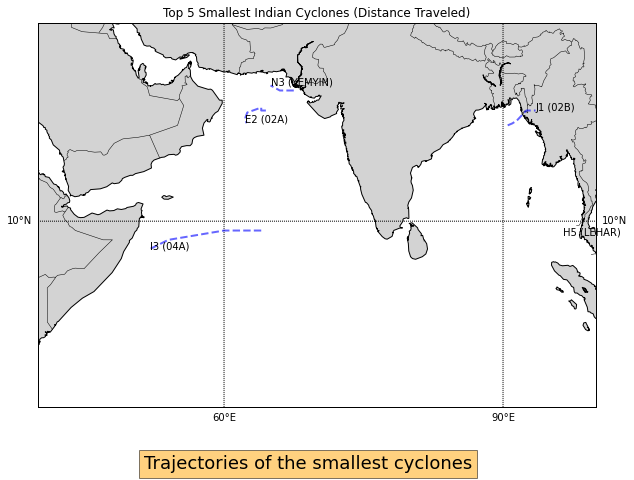

In [101]:
n = 5 # Number of hurricanes

plt.figure(figsize=(10,10))
m = Basemap(llcrnrlon=40.,llcrnrlat=-10.,urcrnrlon=100.,urcrnrlat=30., rsphere=(6378137.00,6356752.3142), resolution='l', projection='merc', lat_0=40.,lon_0=-20.,lat_ts=20.)

m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='#D3D3D3')
m.drawparallels(np.arange(10,90,20),labels=[1,1,0,1])
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])

for x in cyclone_amount.nsmallest(n,0).index:
    largest_hurr = df[df['ID'] == keys[x][1]]
    lat = largest_hurr['Latitude'].values
    long = largest_hurr['Longitude'].values
    xpt, ypt = m(long, lat)
    plt.text(xpt[len(lat) - 1],ypt[len(long) - 1], '%s (%s)' % (keys[x][1].split('-')[0],keys[x][1].split('-')[1]))
    m.plot(xpt, ypt, linewidth=2, color='blue', alpha = 0.6, linestyle = 'dashed')
    
plt.title('Top 5 Smallest Indian Cyclones (Distance Traveled)')
plt.figtext(0.5, 0.15, "Trajectories of the smallest cyclones", ha = "center", fontsize = 18, bbox = {"facecolor": "orange", "alpha": 0.5, "pad": 5})

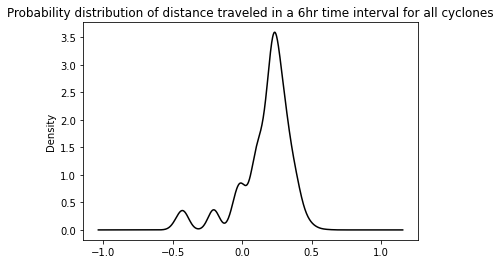

In [108]:
dist = df[df['distance'] > 0]['distance']
dist = np.log(dist)
ser = pd.Series(dist)
ser.plot(kind = 'kde', cmap = 'gray')
plt.title("Probability distribution of distance traveled in a 6hr time interval for all cyclones", loc = 'center');

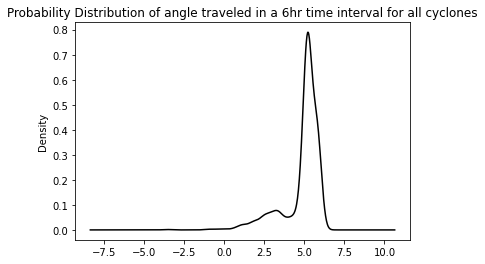

In [110]:
direc = df[df['direction'] > 0]
direc = np.log(direc['direction'])
ser = pd.Series(direc)
ser.plot(kind='kde', cmap='gray')
plt.title('Probability Distribution of angle traveled in a 6hr time interval for all cyclones');

Text(0.5, 1.0, 'Scatterplot of Indian cyclones')

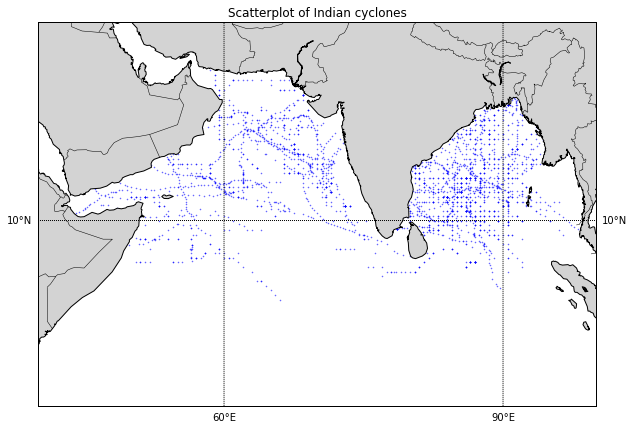

In [113]:
# Graph all points 
plt.figure(figsize=(10, 10))
m = Basemap(llcrnrlon = 40., llcrnrlat = -10., urcrnrlon = 100., urcrnrlat = 30., rsphere = (6378137.00,6356752.3142), resolution = 'l', projection = 'merc', lat_0 = 40., lon_0 = -20., lat_ts = 20.)

m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='#D3D3D3')
m.drawparallels(np.arange(10,90,20),labels=[1,1,0,1])
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])

lat = df['Latitude'].values
long = df['Longitude'].values
xpt, ypt = m(long, lat)
m.scatter(xpt, ypt, .3, color = 'blue', alpha = 0.6)
plt.title('Scatterplot of Indian cyclones')